# Implémentation et expérimentation de l'algorithme de construction d'arbres monotones

In [1]:
import numpy as np
import pandas as pd
import math
import random
from utils import *
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline

### Création de la base jouet :

In [2]:
training_set = LabeledSet(2)

for i in range(0, 3):
    training_set.addExample([random.randint(0,2),random.randint(0,10)],1)
for i in range(0, 3):
    training_set.addExample([random.randint(3, 5), random.randint(0, 10)], 2)
for i in range(0, 4):
    training_set.addExample([random.randint(6, 10), random.randint(0,10)], 3)

In [3]:
df = pd.DataFrame(training_set.x, columns=['x1', 'x2'])
df['label'] = training_set.y
df

,x1,x2,label
0,1,9,1
1,1,9,1
2,2,6,1
3,4,9,2
4,3,4,2
5,4,6,2
6,10,1,3
7,9,6,3
8,8,4,3
9,8,0,3


### Ensembles dominants générés par un attribut/label

In [4]:
def dominant_sets_attribute(a_j, labeled_set):    
    '''
        a_j : index of attribute in labeled_set
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by a_j  
    '''
    values = labeled_set.x.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    for i in range(0, labeled_set.size()):
        v = labeled_set.getX(i)[a_j]
        dominant_sets[i] = set(values[values[:,a_j] >= v][:,labeled_set.getInputDimension()])
                
    return dominant_sets

def dominant_sets_label(labeled_set):
    '''
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by its label  
    '''
    values = labeled_set.y.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    
    for i in range(0, labeled_set.size()):
        v = labeled_set.getY(i)
        dominant_sets[i] = set(values[values[:,0] >= v][:,1])
                
    return dominant_sets
    
dsa_1 = dominant_sets_attribute(0, training_set)
dsa_2 = dominant_sets_attribute(1, training_set)
dsl = dominant_sets_label(training_set)

In [5]:
df_dsa1 = pd.DataFrame(list(dsa_1.items())).drop(0, axis=1)
df_dsa1.columns = ['dominant set generated by first attribute']
df_dsa1

,dominant set generated by first attribute
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
2,"{2, 3, 4, 5, 6, 7, 8, 9}"
3,"{3, 5, 6, 7, 8, 9}"
4,"{3, 4, 5, 6, 7, 8, 9}"
5,"{3, 5, 6, 7, 8, 9}"
6,{6}
7,"{6, 7}"
8,"{8, 9, 6, 7}"
9,"{8, 9, 6, 7}"


In [6]:
df_dsa2 = pd.DataFrame(list(dsa_2.items())).drop(0, axis=1)
df_dsa2.columns = ['dominant set generated by second attribute']
df_dsa2

,dominant set generated by second attribute
0,"{0, 1, 3}"
1,"{0, 1, 3}"
2,"{0, 1, 2, 3, 5, 7}"
3,"{0, 1, 3}"
4,"{0, 1, 2, 3, 4, 5, 7, 8}"
5,"{0, 1, 2, 3, 5, 7}"
6,"{0, 1, 2, 3, 4, 5, 6, 7, 8}"
7,"{0, 1, 2, 3, 5, 7}"
8,"{0, 1, 2, 3, 4, 5, 7, 8}"
9,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"


In [7]:
df_dsl = pd.DataFrame(list(dsl.items())).drop(0, axis=1)
df_dsl.columns = ['dominant set generated by label']
df_dsl

,dominant set generated by label
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
2,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
3,"{3, 4, 5, 6, 7, 8, 9}"
4,"{3, 4, 5, 6, 7, 8, 9}"
5,"{3, 4, 5, 6, 7, 8, 9}"
6,"{8, 9, 6, 7}"
7,"{8, 9, 6, 7}"
8,"{8, 9, 6, 7}"
9,"{8, 9, 6, 7}"


### Construction hiérarchique de mesures de discrimination

#### f-layer :

In [240]:
class F_layer:
    '''
        object-wise local monotonicity measure 
    '''

    def value(self, w_i, labeled_set, esa, esl):
        raise NotImplementedError
        
    def equal_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its equal set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = set(values[values[:,a_j] == v][:,labeled_set.getInputDimension()])

        return dominant_sets
    
    def equal_sets_label(self, labeled_set):    
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] == v][:,1])

        return dominant_sets
    
    def dominant_sets_attribute(self, labeled_set, a_j):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[a_j]
            dominant_sets[i] = set(values[values[:,a_j] >= v][:,labeled_set.getInputDimension()])

        return dominant_sets

    def dominant_sets_label(self, labeled_set):
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] >= v][:,1])

        return dominant_sets

In [241]:
class Ds(F_layer):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return ds value of w_i, a_j
        '''
        esa_i = esa[w_i]
        esl_i = esl[w_i]
        intersection = esa_i.intersection(esl_i)
        
        return len(intersection) * 1.0 / len(esa_i)

In [242]:
ds_2 = Ds()
ds_2_values = []
esa = ds_2.equal_sets_attribute(training_set, 1)
esl = ds_2.equal_sets_label(training_set)
for i in range(0, 10):
    ds_2_values.append(ds_2.value(i, training_set, esa, esl))
pd.DataFrame(ds_2_values, columns=['ds generated by second attribute'])

,ds generated by second attribute
0,0.666667
1,0.666667
2,0.333333
3,0.333333
4,0.500000
5,0.333333
6,1.000000
7,0.333333
8,0.500000
9,1.000000


$dsr(\omega_i)$ :

In [243]:
class Dsr(F_layer):
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return dsr value of w_i, a_j
        '''
        dsa_i = dsa[w_i]
        dsl_i = dsl[w_i]
        intersection = dsa_i.intersection(dsl_i)
        
        return len(intersection) * 1.0 / len(dsa_i)

In [245]:
dsr_1 = Dsr()
dsr_1_values = []
dsa = dsr_1.dominant_sets_attribute(training_set, 0)
dsl = dsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_1_values.append(dsr_1.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_1_values, columns=['dsr generated by first attribute'])

,dsr generated by first attribute
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [246]:
dsr_2 = Dsr()
dsr_2_values = []
dsa = dsr_2.dominant_sets_attribute(training_set, 1)
dsl = dsr_2.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_2_values.append(dsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_2_values, columns=['dsr generated by second attribute'])

,dsr generated by second attribute
0,1.000000
1,1.000000
2,1.000000
3,0.333333
4,0.625000
5,0.500000
6,0.333333
7,0.166667
8,0.250000
9,0.400000


In [247]:
class Minds(F_layer):
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return minds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(equal_set)    

In [248]:
minds_2 = Minds()
minds_2_values = []
esa = minds_2.equal_sets_attribute(training_set, 1)
esl = minds_2.equal_sets_label(training_set)

for i in range(0, 10):
    minds_2_values.append(minds_2.value(i,training_set, esa, esl))
pd.DataFrame(minds_2_values, columns=['minds generated by second attribute'])

,minds generated by second attribute
0,0.333333
1,0.333333
2,0.333333
3,0.333333
4,0.500000
5,0.333333
6,1.000000
7,0.333333
8,0.500000
9,1.000000


$mindsr(\omega_i)$

In [249]:
class Mindsr(F_layer):  
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return mindsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(dominant_set)    

In [250]:
mindsr_1 = Mindsr()
mindsr_1_values = []
dsa = mindsr_1.dominant_sets_attribute(training_set, 0)
dsl = mindsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    mindsr_1_values.append(mindsr_1.value(i,training_set, dsa, dsl))
pd.DataFrame(mindsr_1_values, columns=['mindsr generated by first attribute'])

,mindsr generated by first attribute
0,0.100000
1,0.100000
2,0.125000
3,0.166667
4,0.142857
5,0.166667
6,1.000000
7,0.500000
8,0.250000
9,0.250000


$maxdsr(\omega_i)$

In [251]:
class Maxdsr(F_layer):
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            w_i : index of object in labeled_set
            return maxdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(dominant_set)    

In [252]:
class Maxds(F_layer):

    def value(self, w_i, labeled_set, esa, esl):
        '''
            w_i : index of object in labeled_set
            return maxds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(equal_set)    

$avgdsr(\omega_i)$

In [253]:
class Avgdsr(F_layer):
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
            
        return (1.0/len(dominant_set) * np.sum(intersections_lengths)) * 1.0 / len(dominant_set)    

In [254]:
class Avgds(F_layer):
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
            
        return (1.0/len(equal_set) * np.sum(intersections_lengths)) * 1.0 / len(equal_set)    

In [255]:
avgdsr_2 = Avgdsr()
avgdsr_2_values = []
dsa = avgdsr_2.dominant_sets_attribute(training_set, 1)
dsl = avgdsr_2.dominant_sets_label(training_set)

for i in range(0, 10):
    avgdsr_2_values.append(avgdsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(avgdsr_2_values, columns=['avgdsr generated by second attribute'])

,avgdsr generated by second attribute
0,0.777778
1,0.777778
2,0.472222
3,0.777778
4,0.375000
5,0.472222
6,0.333333
7,0.472222
8,0.375000
9,0.310000


In [256]:
avgds_2 = Avgds()
avgds_2_values = []

esa = avgds_2.equal_sets_attribute(training_set, 1)
esl = avgds_2.equal_sets_label(training_set)

for i in range(0, 10):
    avgds_2_values.append(avgds_2.value(i, training_set, esa, esl))
pd.DataFrame(avgds_2_values, columns=['avgds generated by second attribute'])

,avgds generated by second attribute
0,0.555556
1,0.555556
2,0.333333
3,0.555556
4,0.500000
5,0.333333
6,1.000000
7,0.333333
8,0.500000
9,1.000000


#### g-layer :

In [257]:
class G_layer:
    '''
        object-wise local non-monotonicity measure
    '''
        
    def value(self, f_value):
        raise NotImplementedError

In [258]:
class Log(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log_2(f_value)
        '''
        return -log(f_value, 2) 

In [259]:
class One_minus(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return 1 - f_value
        '''
        return 1 - f_value

#### h-layer :

In [260]:
class H_layer:
    '''
        aggregated local non-monotonicity measure
    '''
        
    def value(self, g_values, labeled_set):
        raise NotImplementedError

In [261]:
class Sum(H_layer):    
    def value(self, g_values, labeled_set):
        '''
            return (1/labeled_set.size()) * sum(g_values)
        '''
        return (1.0/labeled_set.size()) * np.sum(g_values)

#### Rank Shannon discrimination measure $H^*_s(\lambda | a_j)$ :

In [262]:
def rsdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank shannon discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += -log(f_layer.value(i, labeled_set, dsa, dsl), 2)
    return (1.0/n)*H

In [266]:
dsr_shannon = Dsr()
dsa_1 = dsr_shannon.dominant_sets_attribute(training_set, 0)
dsl = dsr_shannon.dominant_sets_label(training_set)
dsa_2 = dsr_shannon.dominant_sets_attribute(training_set, 1)
print("Rank Shannon discrimination measure generated by first attribute : ", rsdm(dsr_shannon, training_set, dsa_1, dsl))
print("Rank shannon discrimination measure generated by second attribute : ", rsdm(dsr_shannon, training_set, dsa_2, dsl))

Rank Shannon discrimination measure generated by first attribute :  0.0
Rank shannon discrimination measure generated by second attribute :  1.0754887502163468


#### Rank Gini discrimination measure $H^*_G(\lambda | a_j)$

In [265]:
def rgdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank gini discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += 1-(f_layer.value(i, labeled_set, dsa, dsl))
    return (1.0/n)*H

In [267]:
dsr_gini = Dsr()
print("Rank Gini discrimination measure generated by first attribute : ", rgdm(dsr_gini, training_set, dsa_1, dsl))
print("Rank Gini discrimination measure generated by second attribute : ", rgdm(dsr_gini, training_set, dsa_2, dsl))

Rank Gini discrimination measure generated by first attribute :  0.0
Rank Gini discrimination measure generated by second attribute :  0.4391666666666667


#### Generic discrimination measure :

In [268]:
class Gdm:
    '''
        Generic rank discrimination measure
    '''
    def __init__(self, h, g, f):
        '''
            h : object-wise local monotonicity measure 
            g : object-wise local non-monotonicity measure 
            f : aggregated local non-monotonicity measure
            labeled_set : labeled set
        '''
        self.h = h 
        self.g = g
        self.f = f
    
    def value(self, labeled_set, a_j):
        g_f = []

        if (isinstance(self.f, Dsr)):
            sa = self.f.dominant_sets_attribute(labeled_set, a_j)
            sl = self.f.dominant_sets_label(labeled_set)
        else:
            sa = self.f.equal_sets_attribute(labeled_set, a_j)
            sl = self.f.equal_sets_label(labeled_set)
        
        for i in range(0, labeled_set.size()):
            g_f.append(self.g.value(self.f.value(i, labeled_set, sa, sl)))
        
        return self.h.value(g_f, labeled_set)

In [269]:
f_layer = Dsr()
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

rsdm = Gdm(h_layer, g_layer_shannon, f_layer)
rgdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Rank Shannon discrimination measure generated by second attribute : " , rsdm.value(training_set, 1))
print("Rank Gini discrimination measure generated by second attribute : " , rgdm.value(training_set, 1))

Rank Shannon discrimination measure generated by second attribute :  1.0754887502163468
Rank Gini discrimination measure generated by second attribute :  0.4391666666666667


In [270]:
f_layer = Ds()
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

sdm = Gdm(h_layer, g_layer_shannon, f_layer)
gdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Conditional Shannon entropy generated by second attribute : " , sdm.value(training_set, 1))
print("Conditional Gini entropy generated by second attribute : " , gdm.value(training_set, 1))

Conditional Shannon entropy generated by second attribute :  0.9509775004326937
Conditional Gini entropy generated by second attribute :  0.4333333333333334


In [271]:
def plot2DSet(labeled_set, title):
    labels = list(set([item for sublist in labeled_set.y.tolist() for item in sublist]))
    mark_dict = {
        ".":"point",
        ",":"pixel",
        "o":"circle",
        "v":"triangle_down",
        "^":"triangle_up",
        "<":"triangle_left",
        ">":"triangle_right",
        "1":"tri_down",
        "2":"tri_up",
        "3":"tri_left",
        "4":"tri_right",
        "8":"octagon",
        "s":"square",
        "p":"pentagon",
        "*":"star",
        "h":"hexagon1",
        "H":"hexagon2",
        "+":"plus",
        "D":"diamond",
        "d":"thin_diamond",
        "|":"vline",
        "_":"hline"
    }    
    S = []
    for label in labels:
        S.append(labeled_set.x[np.where(labeled_set.y == label),:][0])
    for i in range(len(labels)):
        plt.scatter(S[i][:,0],S[i][:,1],marker=list(mark_dict)[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

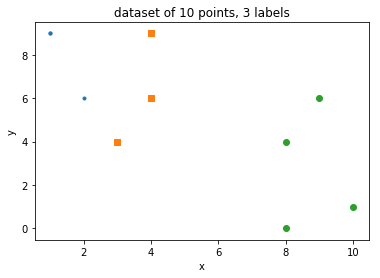

In [272]:
plot2DSet(training_set, "dataset of 10 points, 3 labels")

In [273]:
def display_discretization(labeled_set, threshold, a_j, title):
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold, threshold], [min_v, max_v])
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold, threshold])

    plt.show() 

In [274]:
def display_discretizations_comparison(labeled_set, threshold1, threshold2, threshold, a_j, title, l1, l2, l):
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold1, threshold1], [min_v, max_v], color='green', label=l1)
        plt.plot([threshold2, threshold2], [min_v, max_v], color='red', label=l2)
        if not (threshold is None):
            plt.plot([threshold, threshold], [min_v, max_v], color='black', label=l)
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold1, threshold1], color='green', label=l1)
        plt.plot([min_v, max_v], [threshold2, threshold2], color='red', label=l2)
        if not (threshold is None):
            plt.plot([min_v, max_v], [threshold, threshold], color='black', label=l)
    
    plt.legend()
    plt.show() 

In [301]:
def discretize(H, labeled_set, a_j):
    '''
        H : discrimation measure
        labeled_set : labeled set
        
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values 
    
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        current_label = labeled_set.getY(ind[i])
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        lookahead_label = labeled_set.getY(ind[i+1])
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead or current_label == lookahead_label:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(H.value(binary_set, a_j))
        
    min_entropy = min(H_values)
    min_threshold = thresholds[np.argmin(H_values)]
    
    return (min_threshold, min_entropy)

splitting value generated by rsdm on axis 0 :  6.0
corresponding entropy :  0.1543719518489275
splitting value generated by sdm on axis 0 :  6.0
corresponding entropy :  0.6000000000000001


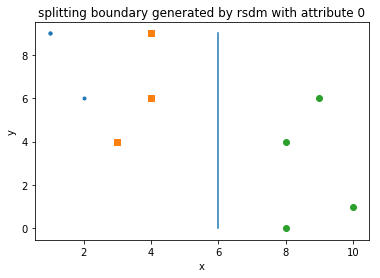

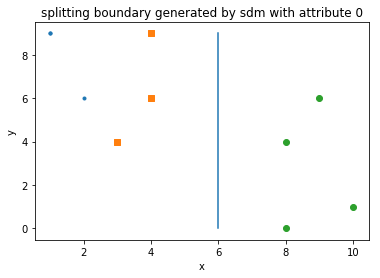

In [302]:
# rsdm 
f = Dsr()
g = Log()
h = Sum()

rsdm = Gdm(h, g, f)

# sdm
f = Ds()
g = Log()
h = Sum()

sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, training_set, 0)
print("splitting value generated by rsdm on axis 0 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set, 0)
print("splitting value generated by sdm on axis 0 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 0, "splitting boundary generated by rsdm with attribute 0")
display_discretization(training_set, threshold_nr, 0, "splitting boundary generated by sdm with attribute 0")

splitting value generated by rsdm on axis 1 :  7.5
corresponding entropy :  0.7901821225930121
splitting value generated by sdm on axis 1 :  5.0
corresponding entropy :  1.2000000000000002


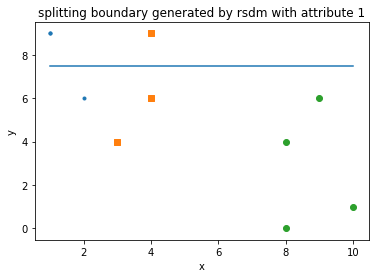

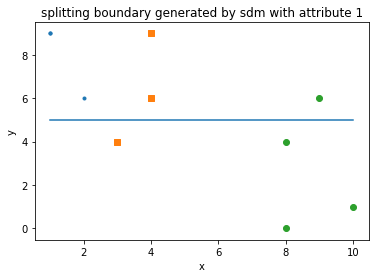

In [303]:
threshold_r, entropy_r = discretize(rsdm, training_set, 1)
print("splitting value generated by rsdm on axis 1 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set, 1)
print("splitting value generated by sdm on axis 1 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 1, "splitting boundary generated by rsdm with attribute 1")
display_discretization(training_set, threshold_nr, 1, "splitting boundary generated by sdm with attribute 1")

In [281]:
def generate_2Ddataset(a_j, k, n, noise, amplitude, ranges):
    '''
        a_j : monotone attribute
        k : number of labels
        n : number of examples to create 
        noise :  % of non-monotone noise
        amplitude : amplitude of noise
        ranges : array of arrays indicating, for each attribute, its min and max values
    '''
    labeled_set = LabeledSet(2)
    p = round(n/k)
    r = n # remaining examples to add 
    
    current_min = ranges[a_j][0]
    total_range = ranges[a_j][1] - ranges[a_j][0]
    
    thresholds = []
    
    for q in range(k):
        current_max = current_min + (total_range / k) 

        if (current_max > ranges[a_j][1]):
            current_max = ranges[a_j][1]
        
        if (current_max < ranges[a_j][1] and q == k-1):
            current_max = ranges[a_j][1] 
        
        
        if (p < r) and (q==k-1):
            p = r

        
        monotone_values = np.random.uniform(current_min, current_max, size=(p,1))
        
        if noise > 0:
            sample_size = np.random.binomial(len(monotone_values), noise)
            sample = np.random.randint(0, len(monotone_values), size=sample_size)
            
            for e in sample:
                if random.random() < 0.5:
                    val = current_min - random.uniform(0, total_range * amplitude)
                    if (val < ranges[a_j][0]):
                        val = ranges[a_j][0]
                    monotone_values[e] = val
                else:
                    val = current_max + random.uniform(0, total_range * amplitude)
                    if (val > ranges[a_j][1]):
                        val = ranges[a_j][1]
                    monotone_values[e] = val
        
        thresholds.append((current_min,current_max) )
        
        if (a_j == 0):
            random_values = np.random.uniform(ranges[1][0], ranges[1][1], size=(p, 1))
            values = np.hstack((monotone_values, random_values))
        else:
            random_values = np.random.uniform(ranges[0][0], ranges[0][1], size=(p,1))
            values = np.hstack((random_values, monotone_values))
        
        for i in range(p):
            labeled_set.addExample(values[i], q+1)
            
        current_min = current_max
        r -= p 
    return labeled_set, thresholds

### Expérimentation sur des bases de données à deux dimensions

In [304]:
f = Dsr()
rsdm = Gdm(h, g, f)

f = Ds()
sdm = Gdm(h, g, f)

### 2 classes : 

splitting value generated by rsdm on axis 0 :  0.0010159922422691148
splitting value generated by sdm on axis 0 :  0.0010159922422691148


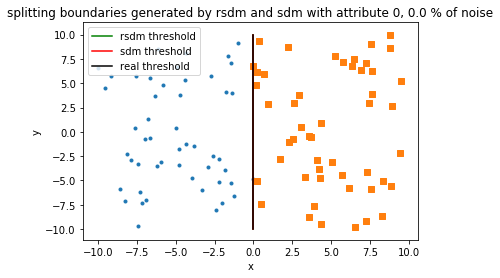

splitting value generated by rsdm on axis 0 :  0.35956461159867337
splitting value generated by sdm on axis 0 :  0.07620297963060507


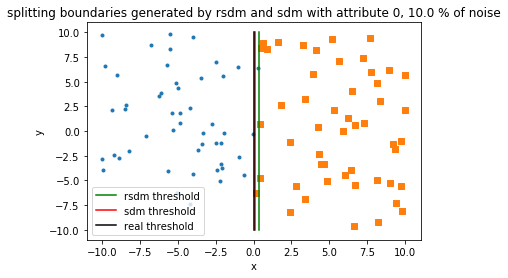

splitting value generated by rsdm on axis 0 :  1.4860090257931788
splitting value generated by sdm on axis 0 :  1.4860090257931788


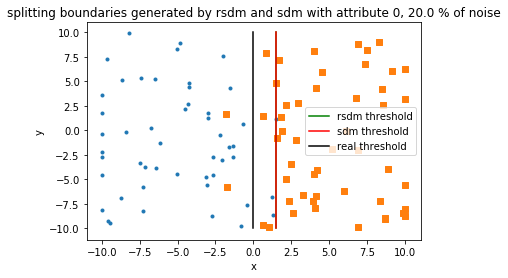

splitting value generated by rsdm on axis 0 :  0.8730548700999029
splitting value generated by sdm on axis 0 :  0.8730548700999029


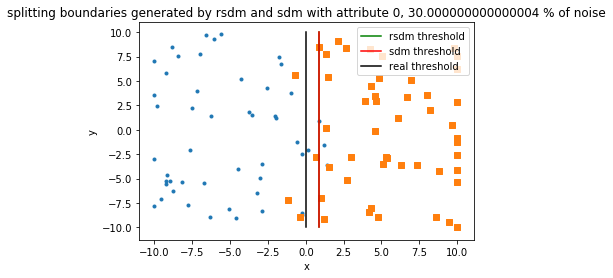

splitting value generated by rsdm on axis 0 :  -2.3457124047402313
splitting value generated by sdm on axis 0 :  -2.3457124047402313


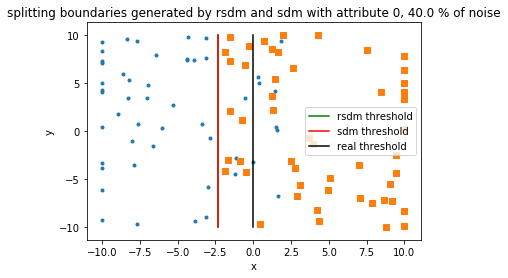

splitting value generated by rsdm on axis 0 :  0.9168693991466971
splitting value generated by sdm on axis 0 :  0.9168693991466971


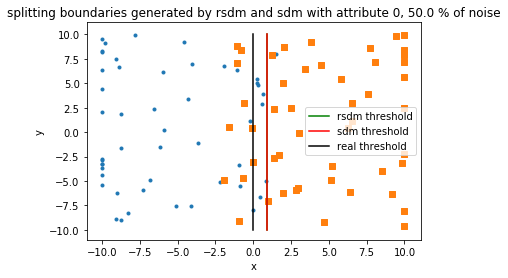

splitting value generated by rsdm on axis 0 :  2.087658324314251
splitting value generated by sdm on axis 0 :  2.087658324314251


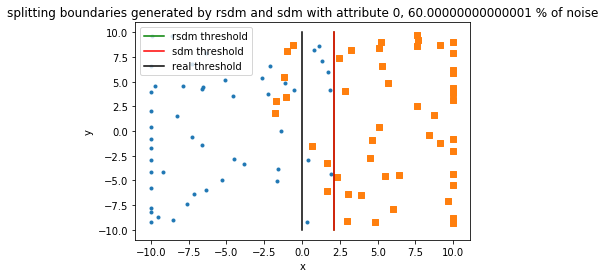

splitting value generated by rsdm on axis 0 :  -2.3133474932505838
splitting value generated by sdm on axis 0 :  -2.3133474932505838


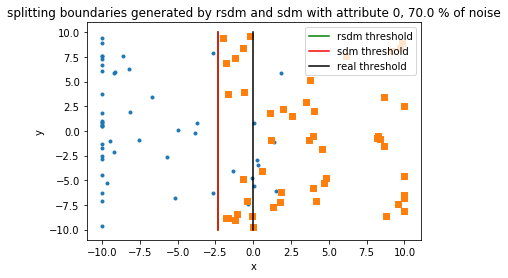

splitting value generated by rsdm on axis 0 :  2.1328854673292175
splitting value generated by sdm on axis 0 :  -1.9692955181289178


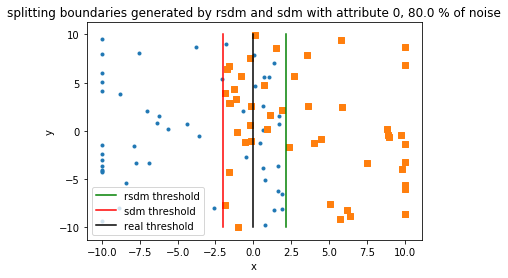

splitting value generated by rsdm on axis 0 :  1.8185379780071265
splitting value generated by sdm on axis 0 :  -1.8230401321853922


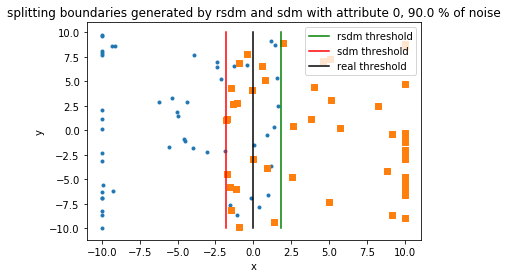

In [305]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

threshold = 0

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    avg_threshold1 = np.average(thresholds1)
    avg_threshold2 = np.average(thresholds2)
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, threshold, 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold", "real threshold")

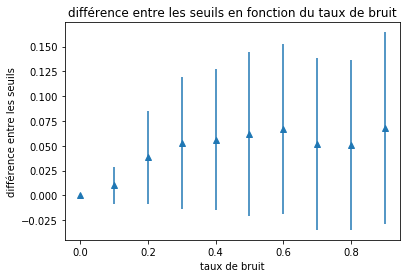

In [306]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20


x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("taux de bruit")
plt.ylabel("différence entre les seuils")
plt.title("différence entre les seuils en fonction du taux de bruit")
plt.show()

In [308]:
noises = np.arange(0., 0.5, 0.05)

threshold = 0

avg_diff_1 = []
avg_diff_2 = []
std_diff_1 = []
std_diff_2 = []

for i in noises:
    threshold_diff1 = []
    threshold_diff2 = []

    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        threshold_diff1.append(fabs(threshold_r - threshold))

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        threshold_diff2.append(fabs(threshold_nr - threshold))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    avg_diff_1.append(np.average(threshold_diff1))
    std_diff_1.append(np.std(threshold_diff1))
    
    avg_diff_2.append(np.average(threshold_diff2))
    std_diff_2.append(np.std(threshold_diff2))

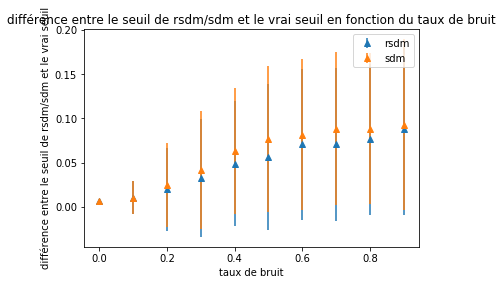

In [310]:
avg_diff_1_norm = np.array(avg_diff_1) / 20
std_diff_1_norm = np.array(std_diff_1) / 20

avg_diff_2_norm = np.array(avg_diff_2) / 20
std_diff_2_norm = np.array(std_diff_2) / 20

x1 = noises
y1 = avg_diff_1_norm
e1 = std_diff_1_norm

x2 = noises
y2 = avg_diff_2_norm
e2 = std_diff_2_norm

plt.errorbar(x1, y1, e, linestyle='None', marker='^', label='rsdm')
plt.errorbar(x2, y2, e, linestyle='None', marker='^', label='sdm')
plt.xlabel("taux de bruit")
plt.ylabel("différence entre le seuil de rsdm/sdm et le vrai seuil")
plt.title("différence entre le seuil de rsdm/sdm et le vrai seuil en fonction du taux de bruit")
plt.legend()
plt.show()

splitting value generated by rsdm on axis 1 :  0.48267733262147594
splitting value generated by sdm on axis 1 :  -9.282468616945046


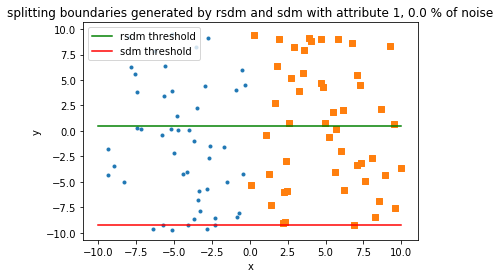

splitting value generated by rsdm on axis 1 :  -2.0040374001585457
splitting value generated by sdm on axis 1 :  8.964626019536999


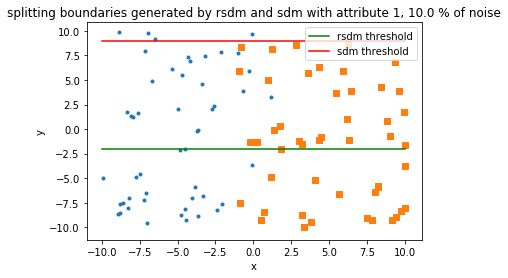

splitting value generated by rsdm on axis 1 :  4.582866120800865
splitting value generated by sdm on axis 1 :  6.430847266643335


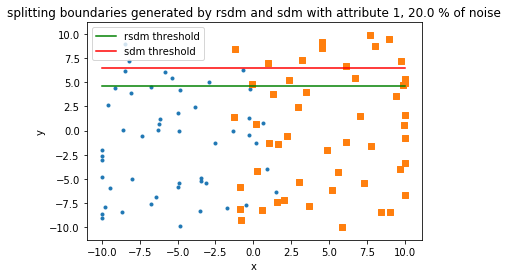

splitting value generated by rsdm on axis 1 :  8.563978924501633
splitting value generated by sdm on axis 1 :  8.563978924501633


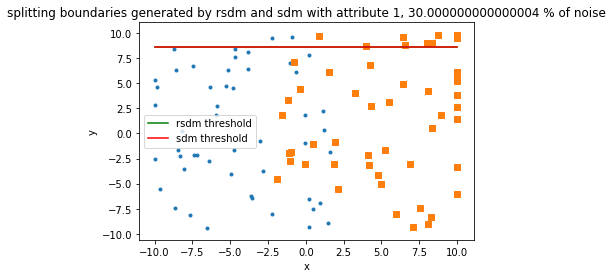

splitting value generated by rsdm on axis 1 :  5.7522898499441295
splitting value generated by sdm on axis 1 :  -8.990976677778047


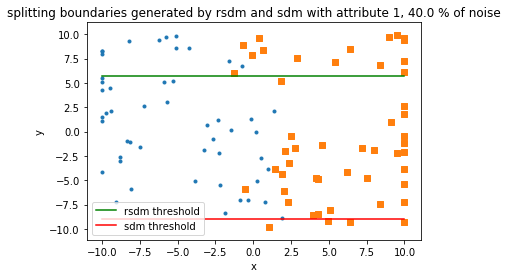

splitting value generated by rsdm on axis 1 :  8.050148639651706
splitting value generated by sdm on axis 1 :  9.469354365810414


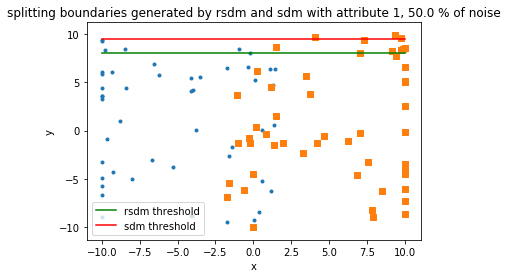

splitting value generated by rsdm on axis 1 :  0.8200283023324921
splitting value generated by sdm on axis 1 :  8.870618812199663


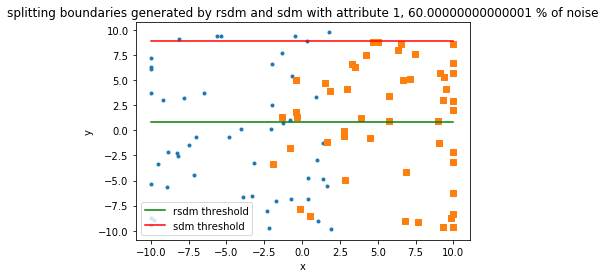

splitting value generated by rsdm on axis 1 :  -0.5563315224412149
splitting value generated by sdm on axis 1 :  -9.680674508629687


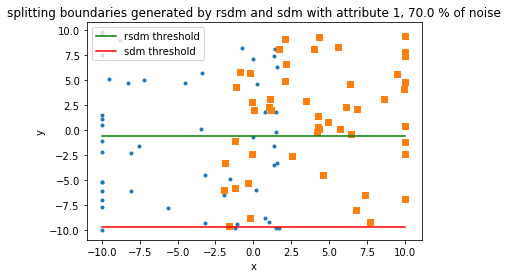

splitting value generated by rsdm on axis 1 :  8.833059547238651
splitting value generated by sdm on axis 1 :  9.753916203350407


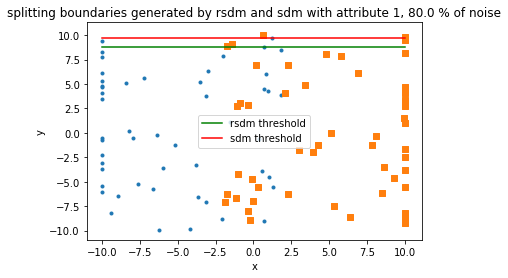

splitting value generated by rsdm on axis 1 :  -8.691156037743433
splitting value generated by sdm on axis 1 :  -8.691156037743433


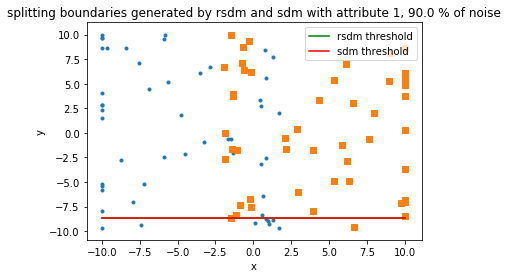

In [311]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set, 1)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 1)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    print("splitting value generated by rsdm on axis 1 : ", threshold_r)
    print("splitting value generated by sdm on axis 1 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, None, 1, "splitting boundaries generated by rsdm and sdm with attribute 1, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold", "real threshold")

In [312]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20
print(avg_diff_norm)
print(std_diff_norm)

[0.34187817 0.3153566  0.3627447  0.31795507 0.39713426 0.28734973
 0.3885829  0.41466198 0.42115197 0.36481977]
[0.28760459 0.26639563 0.30120602 0.28058086 0.30635398 0.27512926
 0.28618481 0.30513592 0.28803964 0.3006924 ]


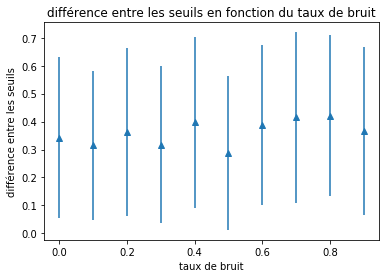

In [313]:
x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("taux de bruit")
plt.ylabel("différence entre les seuils")
plt.title("différence entre les seuils en fonction du taux de bruit")
plt.show()

In [314]:
a_set, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

In [321]:
def discretize_steps(dm, labeled_set, a_j):
    '''
        a_j : index of attribute in labeled_set
        dm : discrimation measure
        labeled_set : labeled set
        
    '''
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values 
    
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(dm.value(binary_set, a_j))
        
    return thresholds, H_values


In [322]:
f = Dsr()
rsdm = Gdm(h, g, f)

f = Ds()
sdm = Gdm(h, g, f)

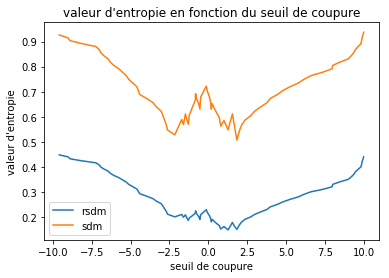

In [323]:
x, y1 = discretize_steps(rsdm, a_set, 0)
x, y2 = discretize_steps(sdm, a_set, 0)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("seuil de coupure")
plt.ylabel("valeur d'entropie")
plt.title("valeur d'entropie en fonction du seuil de coupure")
plt.legend()
plt.show()

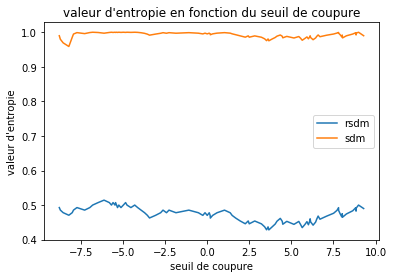

In [324]:
x, y1 = discretize_steps(rsdm, a_set, 1)
x, y2 = discretize_steps(sdm, a_set, 1)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("seuil de coupure")
plt.ylabel("valeur d'entropie")
plt.title("valeur d'entropie en fonction du seuil de coupure")
plt.legend()
plt.show()

### 3 classes

[(-10, -3.333333333333333), (-3.333333333333333, 3.333333333333334), (3.333333333333334, 10.0)]


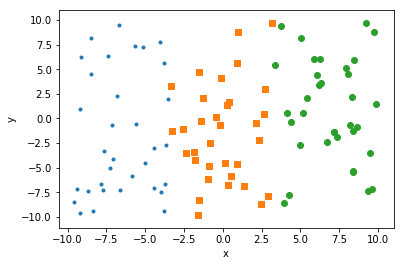

In [330]:
set3, t = generate_2Ddataset(0, 3, 100, 0, 0.1, [[-10, 10], [-10, 10]])
plot2DSet(set3, "")
print(t)

In [334]:
t1 = t[0][1]
t2 = t[2][0]

splitting value generated by rsdm on axis 0 :  3.284757887783973
splitting value generated by sdm on axis 0 :  3.284757887783973


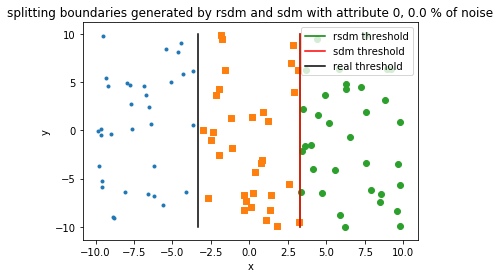

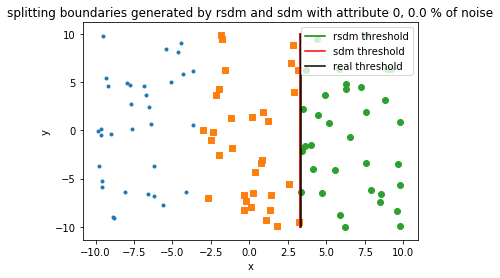

splitting value generated by rsdm on axis 0 :  3.3918809310551974
splitting value generated by sdm on axis 0 :  3.3918809310551974


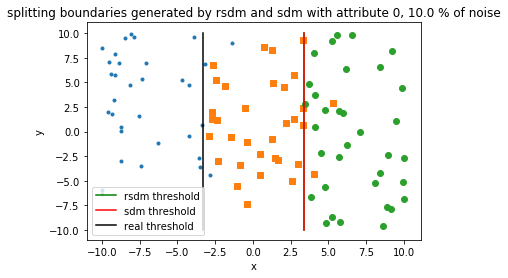

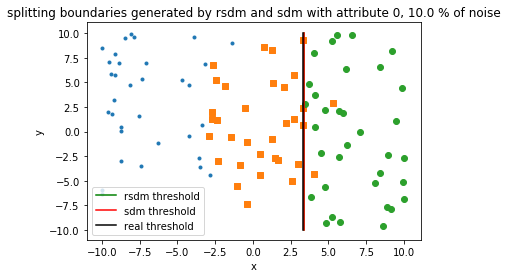

splitting value generated by rsdm on axis 0 :  1.1640615631238895
splitting value generated by sdm on axis 0 :  -3.5285728039113584


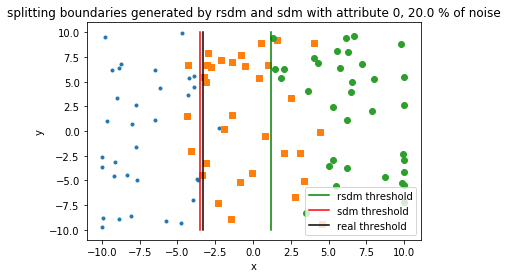

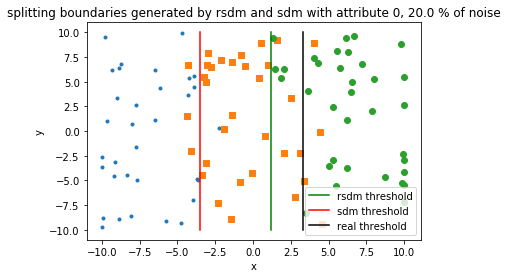

splitting value generated by rsdm on axis 0 :  4.925463227301783
splitting value generated by sdm on axis 0 :  -1.585494840908423


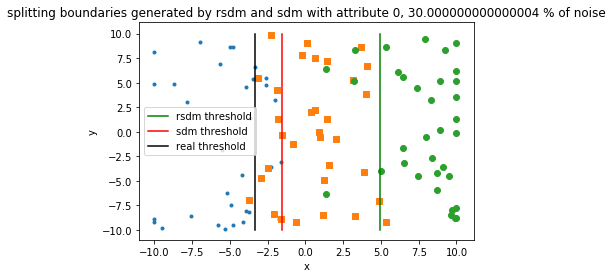

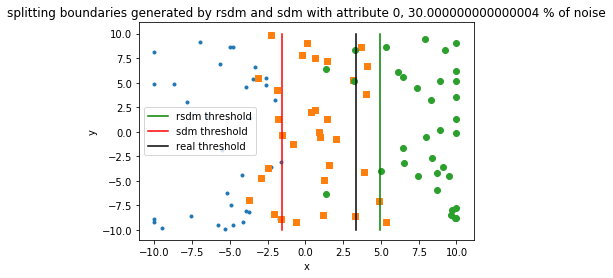

splitting value generated by rsdm on axis 0 :  1.9900157118422677
splitting value generated by sdm on axis 0 :  1.9900157118422677


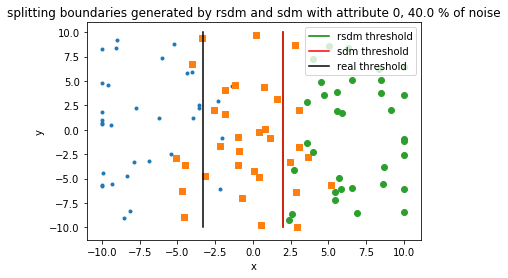

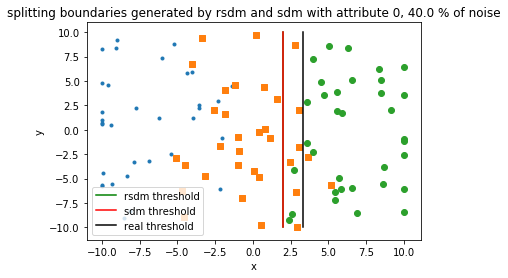

splitting value generated by rsdm on axis 0 :  1.4256505543049396
splitting value generated by sdm on axis 0 :  -1.415515741207129


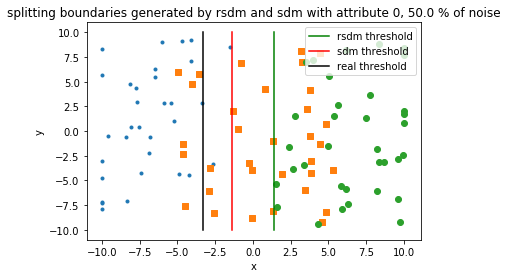

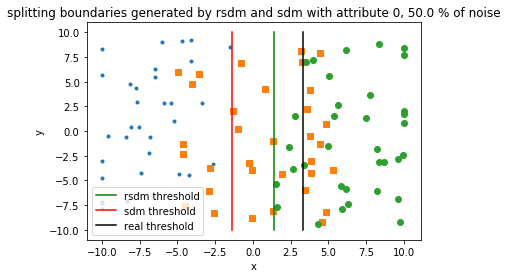

splitting value generated by rsdm on axis 0 :  1.720116308802472
splitting value generated by sdm on axis 0 :  -1.608037207872898


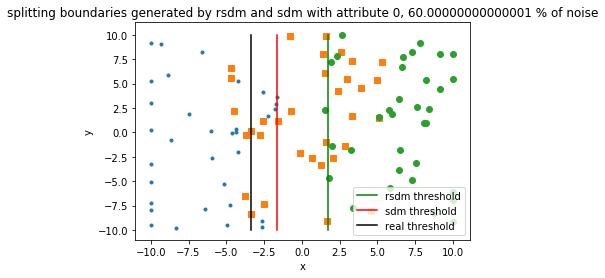

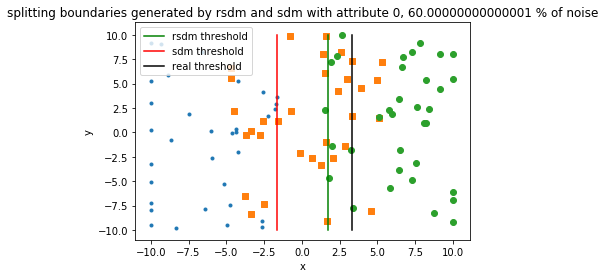

splitting value generated by rsdm on axis 0 :  0.6214941304503354
splitting value generated by sdm on axis 0 :  0.6214941304503354


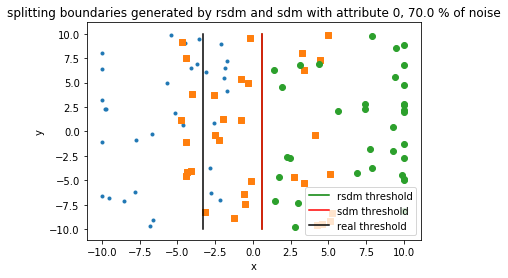

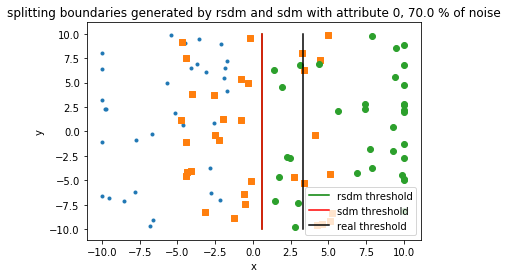

splitting value generated by rsdm on axis 0 :  1.1377383472900546
splitting value generated by sdm on axis 0 :  1.1377383472900546


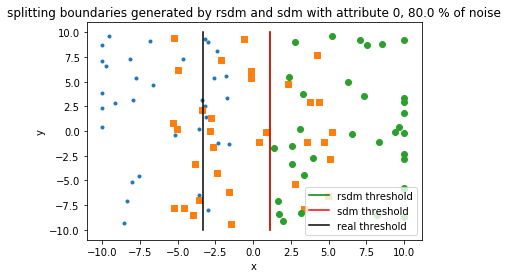

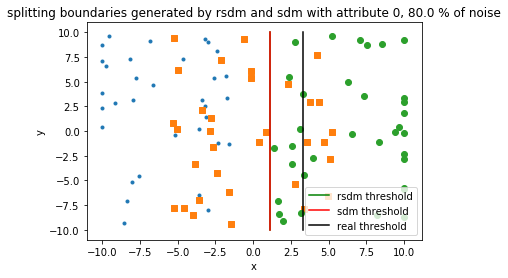

splitting value generated by rsdm on axis 0 :  0.39625036383850154
splitting value generated by sdm on axis 0 :  0.39625036383850154


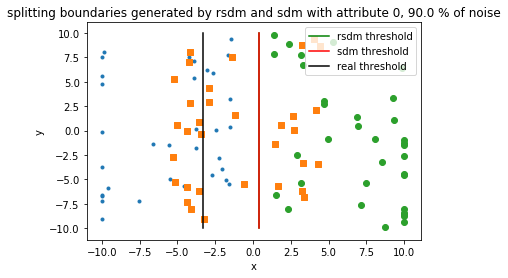

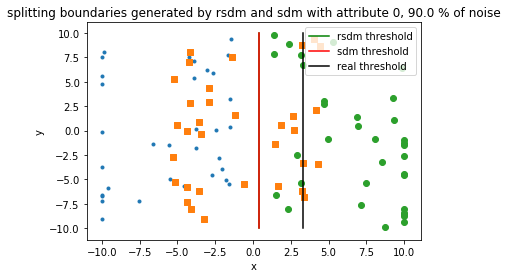

In [336]:
avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 3, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        threshold_r, entropy_r = discretize(rsdm, data_set, 0)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set, 0)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    avg_threshold1 = np.average(thresholds1)
    avg_threshold2 = np.average(thresholds2)
        
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, t1, 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold", "real threshold")
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, t2, 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold", "real threshold")

In [337]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20
print(avg_diff_norm)
print(std_diff_norm)

[0.         0.11341622 0.10597285 0.09672804 0.06809122 0.08306777
 0.08232102 0.06774943 0.06877477 0.04102761]
[0.         0.1476995  0.12009982 0.1024926  0.09572016 0.07812346
 0.07486943 0.07177956 0.07240579 0.05776985]


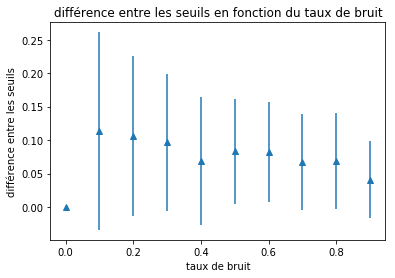

In [338]:
x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("taux de bruit")
plt.ylabel("différence entre les seuils")
plt.title("différence entre les seuils en fonction du taux de bruit")
plt.show()